# Social Media Binary Text Classification using Machine Learning
* Notebook by Adam M. Lang
* Date: 7/1/2024

## Overview
* In this notebook we will perform binary text classification of social meda text using Machine Learning.
* We will do the following:
1. Exploratory Data Analysis (EDA)
2. Text Cleaning & Normalization
3. Create custom embeddings using a Sentence Transformers Model from HuggingFace
4. Binary Classification with:
  * Logistic Regression
  * XGBoost
  * Note:
    * For each of the machine learning classifiers we will perform K folds cross validation and Grid Search for hyperparameter optimization and train the best fit models.
5. We will then compare the best classifier with standard machine learning metric including confusion matrix, accuracy, precision, recall and F1 score.

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
tqdm.pandas(leave=False)

In [ ]:
# I used google colab so comment this out unless you are using colab
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## set your data path
data_path = <your data path here>

In [ ]:
# set random seed for reproducibility
seed = 42
np.random.seed(seed)

In [ ]:
# upload data into pandas dataframe
df = pd.read_csv(data_path)

# sample 10 rows
df.sample(10)

,text,target
677,Thankyou for helping read the results for the ...,False
1591,Congratulations on your remarkable achievement...,False
984,This is in recognition of the amazing job you ...,False
607,"Allison, I want to thank and recognize for all...",False
1392,"John, I want to thank you for the incredible ...",False
1033,"Guys ,everyone showed their metal today in exc...",False
1583,Your kindness does not go unnoticed and I want...,False
1309,"Margarita, I couldn't think of a better exampl...",False
1628,Thanks so much for all of the support as of la...,False
271,Congratulations on your recent work anniversar...,False


## Exploratory Data Analysis

In [ ]:
# let's look at a random sample of the text column
df['text'].sample(20).values

array(["Ladies, it has been a whirlwind the last 3 months of planning, organizing, pivoting ideas, gathering all the most important parts to make sure the experience is smooth and safe! Art Work, Registration, spreadsheets, vendors, shipping, and SUCCESS! Teamwork is what comes from this group and can always make sure there is so much LOVE that goes into each step! Thanks again for being Rockstar's  and making this the best team in the company! We have an award to prove it!",
       "They say behind every good man is a great woman. The same can definitely be said of FE engineers and QA/Automation engineers! I'm constantly grateful for having such a strong safety net to fall back on, so felt it is only worthwhile to share my thanks given the day that's in it. I have every confidence going to production for our first customers knowing that it has been thoroughly checked by hand and is backed up by a comprehensive suite of automation tests.",
       'Danielle has consistently checked in o

Observations:
* The text is not "clean". We can see by random sampling, there are common issues such as:
  1. Upper case and lower case -- the text is not "normalized" which isn't helpful for any NLP machine learning project unless we were using a transformer such as Bert-base-uncased which does not distinguish between uppercase and lowercase words.
  2. punctuation
  3. stop words
  4. special characters
  5. white space
  6. acronyms and abbreviations and 'slang' terms
  7. emoticons (maybe emojis too?)

* If the sentence embeddings were created using the text in this manner without pre-processing or tokenization, I wonder if the embeddings are actually accurate or useful? Yes we are using SBERT sentence transformers which are great at capturing long dependencies as well as subword/wordpiece tokenization so in theory we could assume the embeddings are an accurate depiction of the vector space of our text.
* However, some of the observations I mentioned above can increase the dimensionality of the vector space and take away from the machine learning model's ability to predict the important semantic entities in the dataset.


Plan:
* We should look further at the data including, checking for:
1. Target class imbalance which can bias the machine learning model predictions.
2. Word Frequencies in the dataset. Is the dataset dominated by stop words? Since this is a classification task we may want to think about removing them (just a thought).
3. We could perform "Topic Modeling" just to get an idea of the dominant topics in the text before we make our predictions, but it's not necessary.

In [ ]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638 entries, 0 to 1637
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1638 non-null   object
 1   target  1638 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 14.5+ KB


In [ ]:
# check null values
df.isnull().sum()

text      0
target    0
dtype: int64

In [ ]:
# check df shape and number of unique values in text column
print(f"Shape of dataframe is: {df.shape}")

print(f"Number of unique values are: {df['text'].nunique()}")

Shape of dataframe is: (1638, 2)
Number of unique values are: 1638


In [ ]:
# let's check the target column value_counts before we transform them
# we know its a bool dtype but just to be sure
print(df['target'].value_counts())

target
False    1393
True      245
Name: count, dtype: int64


Summary: Great, we confirmed that the Target column has just 2 bool values True and False, let's proceed with labeling them as 1 for True and 0 for False which is ideal for our binary classification prediction task.

In [ ]:
# transform target column values to 0 and 1
df['target'] = df['target'].map({False: 0, True: 1})

In [ ]:
# now check the target column value_counts
df["target"].value_counts()

target
0    1393
1     245
Name: count, dtype: int64

### Plot the Target Column Value Counts
* Let's plot this so we can see a visualization of the target class imbalance.

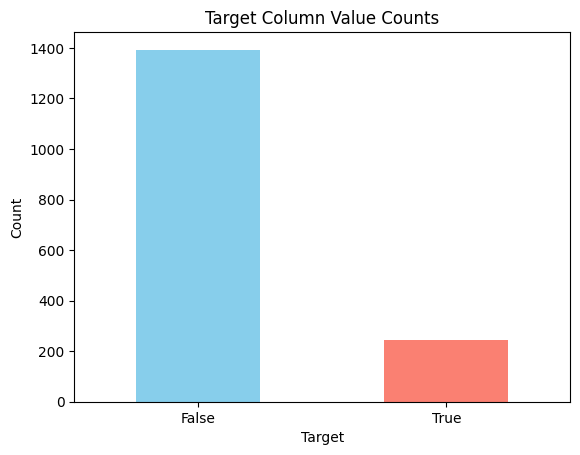

In [ ]:
# plot the target class imbalance
value_counts = df['target'].value_counts()
value_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Column Value Counts')
plt.xticks(ticks=range(len(value_counts)), labels=['False','True'], rotation=0)
plt.xlabel('Target')
plt.ylabel('Count')
plt.show();

Summary:
* This is a problem! There is significant imbalance in the target variable which can lead to significant bias in the modeling predictions.
* Since it is unbalanced, lets upsample the less frequent class.

## Data Augmentation
* I am going to take a different approach to augmenting the minority target class (1 or True).
* The original provided code did not actually address the problem of class imbalance. The code simply separates the dataframe indices into 2 lists based on the target column values 0 or 1. Also, the code block below that uses np.random.choice is just creating an array of random indices without balancing the classes.

### A better approach to upsampling would be to:
1. Determine the size of the majority class.
2. Use np.random.choice with replacement to sample indices from the minority class to match the size of the majority class.
3. Concatenate the original majority class data with the upsampled minority class data to create a balanced DataFrame.

* We could also use a technique like SMOTE (Synthetic Minority Over-sampling Technique) which generates synthetic examples of the minority class using the k-nearest neighbors of these cases. However, creating synthetic samples may not be ideal here.

In [ ]:
## import resample module from sklearn
from sklearn.utils import resample

In [ ]:
# Get counts of each target value
#fifty_fifty_sample_amt = df['target'].value_counts().iloc[0]
df_majority = df[df.target==0]
df_minority = df[df.target==1]

In [ ]:
# Let's look at the shape of the classes
print(f"Shape of majority class: {df_majority.shape}")
print(f"Shape of minority class: {df_minority.shape}")

Shape of majority class: (1393, 2)
Shape of minority class: (245, 2)


In [ ]:
# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True, # sample with replacement
                                 n_samples=len(df_majority), # match number in majority class
                                 random_state=seed) # reproducible results

In [ ]:
# now concatenate the new upsampled data
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [ ]:
# now check the value counts
df_upsampled["target"].value_counts()

target
0    1393
1    1393
Name: count, dtype: int64

Summary:
* We have now upsampled the data using a bootstrap method (sampling with replacement)

## EDA - Continued
* Great, now we have upsampled the data and balanced the target prediction variables.
* However, before I create the `train_test_split`, I want to look at 2 things:
1. Word frequencies - as I mentioned above, I am curious as to the most frequent words in our corpus. Are they stop words? If so do we need to remove them?
2. Text cleaning - as I mentioned above, the text is not entirely clean with noted:

Upper case and lower case -- the text is not "normalized" which isn't helpful for any NLP machine learning project unless we were using a transformer such as Bert-base-uncased which does not distinguish between uppercase and lowercase words.
  * punctuation
  * stop words
  * special characters
  * white space
  * acronyms and abbreviations and 'slang' terms
  * emoticons (maybe emojis too?)



#### Additional Notes I would like to share:
* The acronyms, abbreviations and 'slang' terms as well as 'emoticons' and 'emojis' in the text could be further evaluated, as there are BERT based transformer models and even datasets or corpora to analyze, pre-process and perform text classification.
* While I am not going to do that in this notebook, here are some example resources that could be used for this:
 * Emojis: https://towardsdatascience.com/emojis-aid-social-media-sentiment-analysis-stop-cleaning-them-out-bb32a1e5fc8e
 * Emojis: https://medium.com/@pokharelbikash981/nlp-era-analyzing-texts-with-emojis-fd1a75f81f0f
 * University of Toronto corpora of slang and urban dictionary terms used in social messages: https://www.cs.toronto.edu/~yangxu/data.html
 * Urban Dictionary Dataset: https://metatext.io/datasets/urban-dictionary-dataset
 * SOCBert: pre-trained transformer on twitter and reddit posts
   * paper: https://aclanthology.org/2023.insights-1.5.pdf
   * huggingface: https://huggingface.co/sarkerlab/SocBERT-base
* Emoticon and Emoji Python library and corpus: https://github.com/NeelShah18/emot/tree/master

## Word Frequencies
* I am going to use the CountVectorizer from sklearn to get the most frequent words in the text.
* I am going through this exercise to see what the most frequent words in the dataset are. My hypothesis is that the highest frequency are stop words. The purpose of this is to discuss whether or not to remove stop words, although I will discuss my reasons for vs. against removing stop words after this.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# instantiate the count vectorizer
vectorizer = CountVectorizer()

# fit and transform the text column
X = vectorizer.fit_transform(df_upsampled['text'])

# sum up the counts of each vocabulary word
word_counts = X.sum(axis=0)

# Map from integer feature name to original token string
words = vectorizer.get_feature_names_out()

# create a dictionary of words and their counts
word_freq = {words[i]: word_counts[0,i] for i in range(len(words))}

# print word_freq
print(word_freq)

{'00': 1, '000': 10, '01405806': 1, '02': 1, '05': 1, '07901425': 7, '08': 1, '093': 1, '10': 16, '100': 52, '1000': 2, '100k': 2, '1010': 1, '10x': 1, '10years': 1, '11': 7, '110': 6, '11pm': 3, '11th': 1, '12': 19, '120': 2, '1200': 1, '125': 1, '1273': 1, '12c': 12, '12ps': 1, '13': 2, '130': 1, '1345': 1, '14': 2, '15': 9, '16': 2, '160': 1, '16th': 2, '17': 1, '18': 12, '1873': 1, '188': 3, '19': 24, '19th': 1, '1m': 1, '1s': 1, '1st': 10, '1x1': 1, '20': 18, '200': 1, '2000': 1, '2012': 1, '2017': 5, '2018': 1, '2019': 2, '2020': 19, '2021': 32, '2022': 46, '2023': 36, '2024': 10, '205': 8, '20k': 1, '21': 1, '2170': 1, '22': 15, '224': 1, '2256371a': 3, '22nd': 6, '23': 11, '24': 11, '24hrs': 1, '24r1': 1, '24x7': 1, '25': 2, '2500': 1, '26': 4, '27001': 18, '27th': 6, '28': 3, '29': 7, '29th': 1, '2fa': 4, '2m': 1, '2nd': 6, '2x': 1, '30': 7, '3000': 4, '30am': 2, '30k': 2, '30th': 1, '31': 2, '31st': 3, '33': 1, '350': 2, '3500': 1, '355ml': 1, '360': 2, '37': 3, '3am': 1, '3d

In [ ]:
## sort the dictionary by values
keys = list(word_freq.keys())
values = list(word_freq.values())
sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}


# print the sorted dictionary
print(sorted_dict)

{'00': 1, 'locating': 1, 'locally': 1, 'lobby': 1, 'loans': 1, 'loaniq': 1, 'loaney': 1, 'loan': 1, 'loads': 1, 'loading': 1, 'loa': 1, 'ln18': 1, 'llms': 1, 'llc': 1, 'lizette': 1, 'liverpool': 1, 'liu': 1, 'litter': 1, 'lockdown': 1, 'lit': 1, 'logistic': 1, 'longest': 1, 'lvd': 1, 'lunar': 1, 'luisa': 1, 'luis': 1, 'lubna': 1, 'lsms': 1, 'ls': 1, 'lowest': 1, 'louis': 1, 'lottery': 1, 'losses': 1, 'losing': 1, 'lose': 1, 'lorene': 1, 'lookout': 1, 'lookng': 1, 'longevity': 1, 'logistical': 1, 'listing': 1, 'listens': 1, 'liran': 1, 'liaising': 1, 'lhm': 1, 'lgbtqia': 1, 'lexi': 1, 'leveraging': 1, 'lever': 1, 'level2': 1, 'levant': 1, 'leukemia': 1, 'leozi': 1, 'leon': 1, 'lengthy': 1, 'length': 1, 'len': 1, 'leigh': 1, 'legrand': 1, 'legitimately': 1, 'liaison': 1, 'lianna': 1, 'library': 1, 'liera': 1, 'linnane': 1, 'linking': 1, 'linked': 1, 'lining': 1, 'linguist': 1, 'lingqi': 1, 'linens': 1, 'lincoln': 1, 'lvl': 1, 'lina': 1, 'limerick': 1, 'liletta': 1, 'likeliness': 1, 'ligh

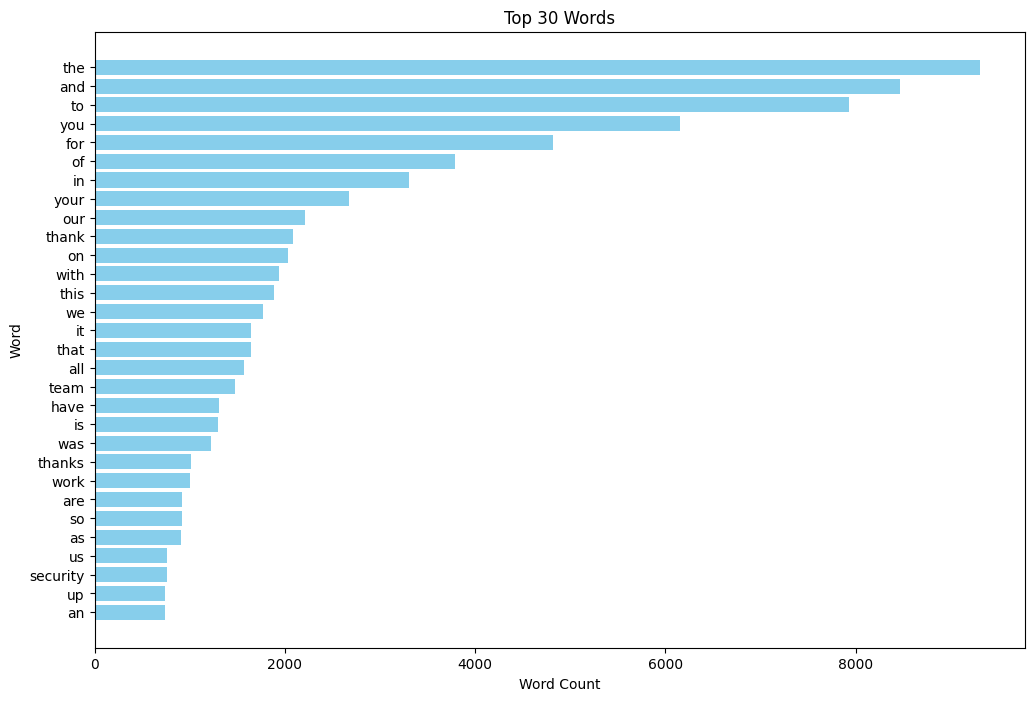

In [ ]:
# plot the top 30 words
plt.figure(figsize=(12, 8))
plt.barh(list(sorted_dict.keys())[-30:], list(sorted_dict.values())[-30:], color='skyblue')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.title('Top 30 Words')
plt.show();

Summary:
* The purpose of this exercise was to show that stop words dominate the dataset.
* It appears that the top 30 words are mostly stop words which was my hypothesis and no surprise to me (or anyone for that matter). The question is whether or not to remove the stop words now? I think it could be debated as to whether or not you should remove the stop words when building a text classification model.
* Removing stop words as a preprocessing step is often **not advised** when using the Sentence Transformers library (as stated in the documentation). Why? The transformer-based embedding models that we are using need the full sentence context in order to create accurate embeddings (hence the reason for using them). Also, the sentence transformers library does automatically ignore the stop words by default to use the attention mechanism to focus on the important words in each sentence. Therefore, I am going to leave the stop words in.

## Clean Text
* A function I wrote to clean the text.
* We will then use it to clean the text.

In [ ]:
import re

# clean text function
def clean_text(text):
    # lower case the text - normalize the case
    text = text.lower()

    # remove punctuation
    text = re.sub('[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\n]', ' ', text)

    # replace hyphen with blank space
    text = re.sub('-', ' ', text)

    # replace double blank spaces
    text = re.sub('  ', ' ', text)

    return text

In [ ]:
## head of df_upsampled
df_upsampled.head()

,text,target
5,"Omkar, Bryan and Weselina were professional to...",0
9,"Thank you, John, for keeping us running the la...",0
11,"Great job guys getting the pump pulled, repair...",0
12,"Thank you for your effort in the cleaning, rea...",0
16,I can't thank you both enough for your efforts...,0


In [ ]:
## check df_upsampled
df_upsampled[['text']].sample(20)

,text
1293,Thanks Martin with all your help to create and...
1297,"Hi folks , I just wanted to say thanks for tak..."
1011,Thanks so much for your help over the past few...
1292,Jillian! Thanks a million for your help with w...
619,"Hi Stephanie, just wanted to drop you a quick ..."
1611,Thanks Darko for quickly remediating an issue ...
1085,Mig - HUGE thank you for troubleshooting Seism...
20,Liza recently joined our API team and already ...
302,"Dear Galit, This week's multi-COE visit to EII..."
467,Glenda has done an impressive job of learning ...


### Now apply the clean_text function

In [ ]:
## apply the clean_text function to the text column and createa new column
df_upsampled['cleaned_text'] = df_upsampled['text'].apply(clean_text)


In [ ]:
## print head of df_upsampled
df_upsampled.head()

,text,target,cleaned_text
5,"Omkar, Bryan and Weselina were professional to...",0,omkar bryan and weselina were professional to ...
9,"Thank you, John, for keeping us running the la...",0,thank you john for keeping us running the last...
11,"Great job guys getting the pump pulled, repair...",0,great job guys getting the pump pulled repaire...
12,"Thank you for your effort in the cleaning, rea...",0,thank you for your effort in the cleaning rear...
16,I can't thank you both enough for your efforts...,0,i can't thank you both enough for your efforts...


### Create a new dataframe with the cleaned_text column

In [ ]:
## create a new dataframe with the cleaned_text column
new_df = df_upsampled[['target','cleaned_text']]
new_df.head()

,target,cleaned_text
5,0,omkar bryan and weselina were professional to ...
9,0,thank you john for keeping us running the last...
11,0,great job guys getting the pump pulled repaire...
12,0,thank you for your effort in the cleaning rear...
16,0,i can't thank you both enough for your efforts...


In [ ]:
## new_df - check value_counts for target
new_df.target.value_counts()

target
0    1393
1    1393
Name: count, dtype: int64

In [ ]:
## new_df - check dimensions
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2786 entries, 5 to 62
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   target        2786 non-null   int64 
 1   cleaned_text  2786 non-null   object
dtypes: int64(1), object(1)
memory usage: 65.3+ KB


## Feature Engineering
* Now that we have cleaned the text we will create the train_test_split.
* We wil do this before creating custom embeddings to prevent "data leakage".

In [ ]:
# import train_test_split
from sklearn.model_selection import train_test_split



## setup X and y features
X = new_df.drop('target',axis=1)
y = new_df['target']

In [ ]:
## quick check of X
print(X[0:10])

                                         cleaned_text
5   omkar bryan and weselina were professional to ...
9   thank you john for keeping us running the last...
11  great job guys getting the pump pulled repaire...
12  thank you for your effort in the cleaning rear...
16  i can't thank you both enough for your efforts...
19  sara had a great catch while admitting a patie...
23  thank you didi for always being helpful and in...
25  great job identifying id theft today and savin...
27  justin seen me struggling taking a pallet of p...
28  great job identifying id theft today and savin...


In [ ]:
## quick check of y
print(y[0:10])

5     0
9     0
11    0
12    0
16    0
19    0
23    0
25    0
27    0
28    0
Name: target, dtype: int64


In [ ]:
# create train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)



In [ ]:
# shape of train and test
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_text: {y_test.shape}")

Shape of X_train: (2228, 1)
Shape of X_test: (558, 1)
Shape of y_train: (2228,)
Shape of y_text: (558,)


## Embeddings
* I am going to recreate the embeddings now that we have upsampled the target data class and done some additional EDA as well as text cleaning.
* I am going to take a different approach to creating the embeddings using batching. I am going to write a function to do this.
* **Note for the code below to work you need a HuggingFace token.**

In [ ]:
# import libraries
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
from typing import List
import torch

In [ ]:
# Load tokenizer and model from HuggingFace
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")

# Move model to GPU if available - setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
## function to create embeddings
def create_embeddings(texts: List[str], batch_size: int):
    all_embeddings = []
    print(f"Total number of records: {len(texts)}")
    print(f"Num batches: {(len(texts) // batch_size) + 1}")

    # Extract embeddings for the texts in batches
    for start_index in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[start_index:start_index + batch_size]

        # Generate tokens and move input tensors to GPU
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Extract the embeddings. no_grad because the gradient does not need to be computed
        # since this is not a learning task
        with torch.no_grad():
            outputs = model(**inputs)

        # Get the last hidden stated and pool them into a mean vector calculated across the sequence length dimension
        # This will reduce the output vector from [batch_size, sequence_length, hidden_layer_size]
        # to [batch_size, hidden_layer_size] thereby generating the embeddings for all the sequences in the batch
        last_hidden_states = outputs.last_hidden_state
        embeddings = torch.mean(last_hidden_states, dim=1).cpu().tolist()

        # Append to the embeddings list
        all_embeddings.extend(embeddings)

    return all_embeddings

## Create Embeddings

* Here we will apply the **create_embeddings** functions

In [ ]:
# Create embeddings for the training and test set
## train set embeddings
train_embeddings = create_embeddings(texts=X_train["cleaned_text"].tolist(), batch_size=256)
train_embeddings_df = pd.DataFrame(train_embeddings)

## test set embeddings
test_embeddings = create_embeddings(texts=X_test["cleaned_text"].tolist(), batch_size=256)
test_embeddings_df = pd.DataFrame(test_embeddings)

Total number of records: 2228
Num batches: 9


100%|██████████| 9/9 [16:44<00:00, 111.61s/it]


Total number of records: 558
Num batches: 3


100%|██████████| 3/3 [04:56<00:00, 98.88s/it]


In [ ]:
## lets get the class counts
from collections import Counter

# get class counts
print(Counter(y_train))

Counter({0: 1114, 1: 1114})


## Modeling
* Now we can build the Text Classification Models

### Model 1: Logistic Regression
- First we will perform grid search and cross validation to find the best hyperparameters.
- Then we will fit a logistic regression model with these parameters.

In [ ]:
# import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

### Note about hyperparameters:
* **Regularization** is a technique used to **avoid overfitting in machine learning models.** It does this by adding a penalty term to the objective function (also called the loss function or error function) that the model is trying to minimize.
* The objective function measures the error or difference between the predicted output of the model and the true output.
* In logistic regression, the objective function is typically the cross-entropy loss, which measures the difference between the predicted probability of the positive class and the true label (1 or 0).
* If we add a penalty term to the objective function, **regularization helps to reduce the complexity of the model and prevent it from overfitting or memorizing the training data.**
* The penalty term is a hyperparameter that controls the strength of the regularization. A higher value for the penalty term leads to stronger regularization and a simpler model, while a lower value allows the model to be more complex.
* Some of the parameters that we will search in GridSearch below are:
    * **penalty:** L2 is also known as Ridge regularization. It adds a penalty to the objective function which is equal to the square of coefficients. All model coefficients will then be close to zero but not equal to zero. This is better than L1 or Lasso regularization because it is less prone to overfitting.
    * **solvers:** These are the various solvers available in sklearn, we will test out a few of the most common ones.
    * The "C" hyperparameters are represented by the 'c_vals' params below. These are different values that control the strength of the regularization. A small value of C (e.g. 0.01) will result in stronger regularization and a more "simple" model, whereas a larger value of C (e.g. 1.0) will result in weaker regularization and a more "complex" model.

In [ ]:
# high regularization for interpretability and sparseness
logisticRegr = LogisticRegression()

# solvers
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
cross_vals = [100, 50, 10, 1.0, 0.1, 0.01]

In [ ]:
# setup gridsearch
grid = dict(solver=solvers,penalty=penalty,C=cross_vals)
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)



# perform gridsearch
log_reg_grid = GridSearchCV(estimator=logisticRegr, param_grid=grid, n_jobs=-1, cv=cross_val, scoring='accuracy',error_score=0)

# fit the model
log_reg_grid.fit(train_embeddings_df, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42),
             error_score=0, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [100, 50, 10, 1.0, 0.1, 0.01], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

## Summarize Results and find best hyperparameters

In [ ]:
#logisticRegr.fit(train_embs, train["target"])

## Summarize results and find best hyperparameters
print("The best hyperparameters are: ", log_reg_grid.best_score_, log_reg_grid.best_params_)
means = log_reg_grid.cv_results_['mean_test_score']
stds = log_reg_grid.cv_results_['std_test_score']
params = log_reg_grid.cv_results_['params']
## loop through the params
for mean, stdev, param in zip(means, stds, params):
    print(f"Mean: {mean}, Stdev: {stdev}, Param: {param}")

The best hyperparameters are:  0.9504874829986937 {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Mean: 0.9494418185001142, Stdev: 0.014105510018838707, Param: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Mean: 0.9497394255241787, Stdev: 0.013941606687813106, Param: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Mean: 0.9504874829986937, Stdev: 0.014277045402624429, Param: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Mean: 0.949889575674329, Stdev: 0.013972677803365708, Param: {'C': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
Mean: 0.9501885293365114, Stdev: 0.014034071198843976, Param: {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
Mean: 0.9500377058673024, Stdev: 0.014889483010117801, Param: {'C': 50, 'penalty': 'l2', 'solver': 'liblinear'}
Mean: 0.9501878560174525, Stdev: 0.014871791191018396, Param: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Mean: 0.9501878560174525, Stdev: 0.014871791191018396, Param: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Mean: 0.94974

## Fit the best Logistic Regression Model

In [ ]:
## Fit the best model
log_reg_best = LogisticRegression(**log_reg_grid.best_params_)
log_reg_best.fit(train_embeddings_df, y_train)

LogisticRegression(C=100, solver='liblinear')

## Predict on Test set for Logistic Regression

In [ ]:
#preds = logisticRegr.predict(test_embs)


# predict on test set
log_reg_preds = log_reg_best.predict(test_embeddings_df)
log_reg_pred_probs = log_reg_best.predict_proba(test_embeddings_df)
log_reg_probs = log_reg_pred_probs[:,1]

## Evaluation Metrics for Logistic Regression

In [ ]:
# imports
from sklearn.metrics import classification_report, confusion_matrix


# print confusion matrix
log_reg_conf_mat = confusion_matrix(y_test, log_reg_preds)
# print raw confusion matrix
print('Confusion Matrix for best Logistic Regression Model\n')
print(log_reg_conf_mat)

Confusion Matrix for best Logistic Regression Model

[[253  26]
 [  0 279]]


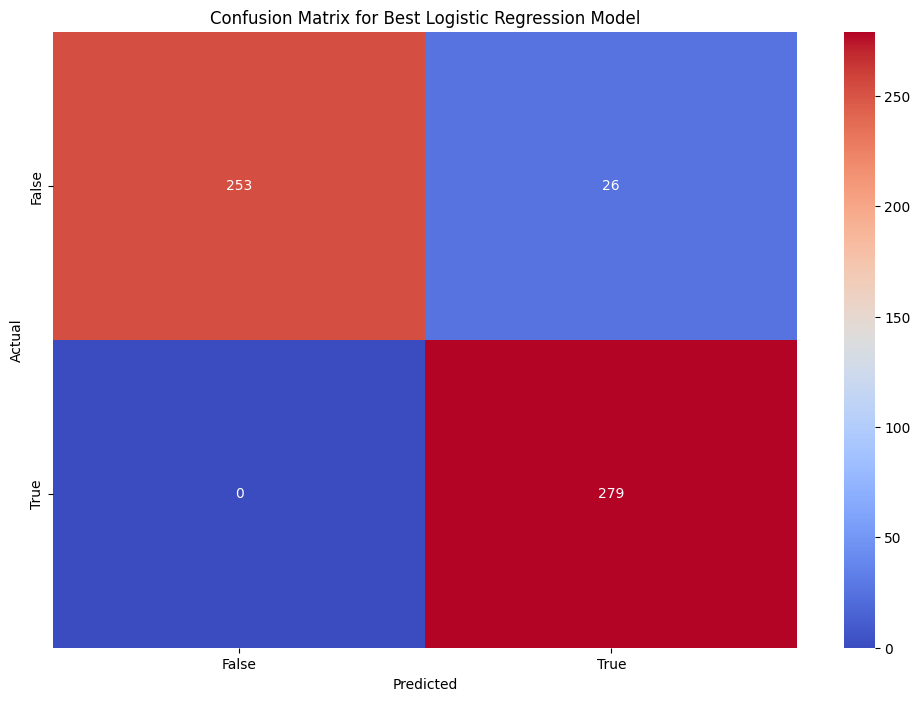

In [ ]:
## visualize the confusion matrix
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(log_reg_conf_mat, annot=True, fmt='d', cmap='coolwarm', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Best Logistic Regression Model')
plt.show();

# Summary of Confusion Matrix for Logistic Regression Model
* True Negatives (False): 253
* True Positives (True): 279
--------------------------------
* False Positives: 26
* False Negatives: 0
--------------------------------
* Thus we can concluded that the Logistic Regression model classified 279 of the messages as True or related to Safety or Security and 253 of the messages as False or not related.
* There were 26 false positives so it would be interesting to look closer at these to see why they were classified as false positive.


In [ ]:
## print classification report for Logistic Regression
target_names = ['False', 'True']
print('Classification Report for Best Logistic Regression Model\n')
## print the classification report
print(classification_report(y_test, log_reg_preds, target_names=target_names))

Classification Report for Best Logistic Regression Model

              precision    recall  f1-score   support

       False       1.00      0.91      0.95       279
        True       0.91      1.00      0.96       279

    accuracy                           0.95       558
   macro avg       0.96      0.95      0.95       558
weighted avg       0.96      0.95      0.95       558



# Summary of Classification Report for Best Logistic Regression Model
* The overall model accuracy (or how often the model is correct overall) was 0.95 or 95%.
* The precision which shows us how often the model is correct when predicting the target class was 100% for predicting False and 91% for predicting True.
* The recall which shows us how well our model can find all objects in the target class was 91% for False and 100% for True. **This makes complete sense as there is a 'precision-recall trade-off' that often occurs with one being higher than the other.
* The F1 score or harmonic mean of both the precision and accuracy was similar for both classes at 95% for False and 96% for True.
* Overall it seems this model performed quite well on performing the binary classification.

In [ ]:
# score the model
lr_score = log_reg_best.score(test_embeddings_df, y_test)
lr_score

0.953405017921147

# Summary of Logistic Regression Model
* We can say that the model did pretty well overall with an accuracy of 95% and the F1 score for both classes False and True was 95% and 96% respectively.
* There were more true positives or 1 predicted for classifying the text as "Safety or Security" than true negatives. There were 26 false positives and no false negatives. It would be prudent to take a closer look at these false positives and understand why this happened.



## Model 2: XGBoost
* We want to use a classifier model to perform classification on our text.
* I am going to use the `RandomizedSearchCV` instead of `GridSearchCV` because of the time and amount of GPUs it will take to perform a full gridsearch.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Move model to GPU if available - setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Train XGBoost Classifier
* First I am going to create a custom callback class to use with XGBoost so I know how long it took to train the model. XGBoost does not have built in callbacks to do this which is why I am creating a custom class.

In [ ]:
from tqdm import tqdm
from xgboost.callback import TrainingCallback

# Creating a custom callback to integrate tqdm progress bar with XGBoost
class TQDMCallback(TrainingCallback):
    def __init__(self, verbose=True):
        self.verbose = verbose

    def before_training(self, model):
        self.pbar = tqdm(total=model.attr('num_boost_round'), disable=not self.verbose)
        return model

    def after_iteration(self, model, epoch, evals_log):
        self.pbar.update(1)
        return False

    def after_training(self, model):
        self.pbar.close()
        return model



In [ ]:
# Initialize the XGBoost Classifier Model with early stopping
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            random_state=seed,
                            device=device,
                            eval_metric='logloss',
                            early_stopping_rounds=10,
                            callbacks=[TQDMCallback()],
                            use_label_encoder=False)

# Define the hyperparameters and values to search
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],

}

# Setup randomized search instead of grid search for efficiency
xgb_random = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist, n_iter=10, scoring='accuracy', n_jobs=-1, cv=cross_val, verbose=3, random_state=seed)


In [ ]:
# Fit the XGBoost model
xgb_random.fit(train_embeddings_df, y_train, eval_set=[(train_embeddings_df, y_train)], verbose=False)

# Summarize results and find best hyperparameters
print("The best hyperparameters are: ", xgb_random.best_score_, xgb_random.best_params_)
print("The best learning rate is: ", xgb_random.best_params_['learning_rate'])
print("The best max depth is:", xgb_random.best_params_['max_depth'])
print("The best n_estimators are: ", xgb_random.best_params_['n_estimators'])

Fitting 30 folds for each of 10 candidates, totalling 300 fits


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:03:44] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
100it [00:21,  4.72it/s]


The best hyperparameters are:  0.9808568658344442 {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}
The best learning rate is:  0.1
The best max depth is: 7
The best n_estimators are:  100


In [ ]:
## define the best params for the classifier fit below
best_max_depth = xgb_random.best_params_['max_depth']
best_n_estimators = xgb_random.best_params_['n_estimators']
best_learning_rate = xgb_random.best_params_['learning_rate']

In [ ]:
print(best_max_depth)
print(best_n_estimators)
print(best_learning_rate)

7
100
0.1


### Now fit the best XGBoost Model

In [ ]:
## fit the final best XGBoost model
xgb_best = xgb.XGBClassifier(max_depth=best_max_depth, n_estimators=best_n_estimators,
                             eta=best_learning_rate,
                             objective='binary:logistic',
                             eval_metric='logloss',
                             random_state=seed)



# fit the best model
xgb_best.fit(train_embeddings_df, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

## Fit on test set for XGBoost Model

In [ ]:
# predict on test set
xgb_preds = xgb_best.predict(test_embeddings_df)
xgb_pred_probs = xgb_best.predict_proba(test_embeddings_df)
xgb_probs = xgb_pred_probs[:,1]



## Evaluation Metrics for XGBoost

In [ ]:
# print confusion matrix
conf_mat_xgb = confusion_matrix(y_test, xgb_preds)
# print raw confusion matrix
print('Confusion Matrix for best Logistic Regression Model\n')
print(conf_mat_xgb)

Confusion Matrix for best Logistic Regression Model

[[272   7]
 [  0 279]]


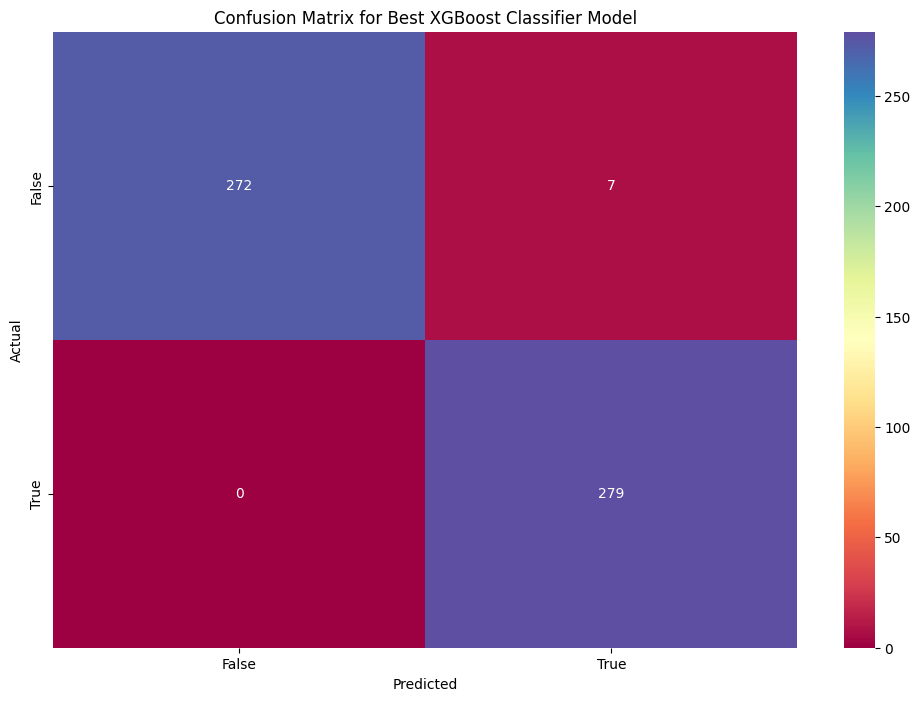

In [ ]:
## visualize the confusion matrix for xgboost classifier
plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat_xgb, annot=True, fmt='d', cmap='Spectral', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Best XGBoost Classifier Model')
plt.show();

# Summary of Confusion Matrix for XGBoost Classifier Model
* True Negatives (False): 272
* True Positives (True): 279
--------------------------------
* False Positives: 7
* False Negatives: 0
--------------------------------
* Thus we can concluded that the XGBoost model classified 279 of the messages as True or related to Safety or Security which was the exact same number of True positives that the Logistic Regression Model classified.
* The XGBoost model also classified 272 True Negatives as compared to the 253 True Negatives by the Logistic Regression Model as False or not related. So the XGBoost model performed better here.
* Compared to the Logistic Regression model, the XGBoost model had significantly less false positives with only 7 compared to 26 false positives with the Logistic Regression model so it would be interesting to see what those 7 false positives were. But, this is a good sign that the XGBoost model performed better on the dataset.
* Both models XGBoost and Logistic Regression had zero false negatives.


In [ ]:
## print classification report for Logistic Regression
target_names = ['False', 'True']
print('Classification Report for Best Logistic Regression Model\n')
## print the classification report
print(classification_report(y_test, xgb_preds, target_names=target_names))

Classification Report for Best Logistic Regression Model

              precision    recall  f1-score   support

       False       1.00      0.97      0.99       279
        True       0.98      1.00      0.99       279

    accuracy                           0.99       558
   macro avg       0.99      0.99      0.99       558
weighted avg       0.99      0.99      0.99       558



# Summary of Classification Report for Best XGBoost Model (and comparision to the Logistic Regression Model)
* The overall model accuracy (or how often the model is correct overall) was 0.99 or 99% as compared to the Logistic Regression model which was 0.95 or 95%.
* The precision which shows us how often the model is correct when predicting the target class was 100% for predicting False which was the same result for Logistic Regression and 98% for predicting True as compared to only 91% for predicting True for the Logistic Regression Model.
* The recall which shows us how well our model can find all objects in the target class was 97% for False and 100% for True. Again the recall was better for the XGBoost model. **This makes complete sense as there is a 'precision-recall trade-off' that often occurs with one being higher than the other.
* The F1 score or harmonic mean of both the precision and accuracy was the same for both classes at 99% which is near perfect text classification as compared to the Logistic Regression model which had F1 scores of 95% for False and 96% for True.

In [ ]:
# score the model
xgb_score = xgb_best.score(test_embeddings_df, y_test)
xgb_score

0.9874551971326165

## Compare Error Ratio between models

In [ ]:
## calculate the error ratio between models using the built-in mean accuracy score from sklearn
error_ratio = (1-lr_score) / (1-xgb_score)
error_ratio

3.714285714285728

# Overall Summary
* The XGBoost model overall performed much better than Logistic Regression with a final mean accuracy score of 98.7% compared to Logistic Regression which was 95.3%.
* The XGBoost model also was able to classify the same number of True positives as the Logistic Regression model and was better at classifying the True Negatives than the Logistic Regression model.
* It would be interesting to compare the XGBoost model to other classifiers or even a transformer BERT based model, but I do feel based on these observations that the XGBoost model really is the best model for the classification task as proven by the evaluation metrics.
